# Product Sentiment Analysis - NLP

* Student name: Robert Cauvy 
* Student pace: Flex
* Scheduled project review date/time: 
* Instructor name: Claude Fried

## TABLE OF CONTENTS 

*Click to jump to matching Markdown Header.*<br><br>
 
- **[Introduction](#INTRODUCTION)<br>**
- **[OBTAIN](#OBTAIN)**<br>
- **[SCRUB](#SCRUB)**<br>
- **[EXPLORE](#EXPLORE)**<br>
- **[MODEL](#MODEL)**<br>
- **[iNTERPRET](#iNTERPRET)**<br>
- **[Conclusions/Recommendations](#CONCLUSIONS-&-RECOMMENDATIONS)<br>**
___

# INTRODUCTION

Hired by Apple to determine which product release has the more positive sentiment and how it compared to their competitor Google who had also just released a new service.

Over the past decade conversations have increasingly shifted towards social media. Businesses across all industries could stand to benefit from listening to these conversations about themselves and how their products and brand are perceived by they users and prospective customers. Understanding what it is that customers enjoy the most and the least about your company's products and brand is crucial to retaining your loyal customers as well as attracting new ones.

When large companies announce their new product releases at conferences and keynotes, they can obtain useful market insights and feedback from public opinion. A great source to measure market reactions is the giant social media network, Twitter.

In addition to analyzing tweets various machine learning models will be trained and tested to classify tweets as either positive or negative sentiments towards the companies products and services. 

## Business Problem

It is not easy to obtain unbiased and unfiltered feedback and opinions from the public. Understanding how the market feels about the products and services delivered by your brand in real-time can provide valuable insights that could not get captured before the ubiquity of social media. Applying human capital to track social networks is simply not a scalable solution which makes the application of Natural Language Processing and Machine Learning classifiers well suited for this business problem.

The objective of this project is provide the businesses (Apple and Google) a model that identifies which tweets hold either a positive or negative sentiment about their brand or products from a corpus of tweets. Furthermore, this project will provide the stakeholders with a list of topics and keywords that most affect public perception, leaving actionable insights for future marketing and product design decisions.


# OBTAIN

In [92]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import pandas as pd
import math


from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import (CountVectorizer,TfidfTransformer, 
                                             TfidfVectorizer,ENGLISH_STOP_WORDS)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import nltk 
from nltk import TweetTokenizer, word_tokenize,wordpunct_tokenize
import string
from wordcloud import WordCloud


from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

pd.set_option("display.max_colwidth", 300)

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Data Understanding

This project is utilizing a dataset  provided by CrowdFlower to from data.world. The dataset contains over 9,000 tweets from SXSW(South by Southwest) Conference about new product releases from Apple and Google. The tweet have been labeled as to which emotion they convey towards a particular product category or company brand based off of the language contained in the tweet.

According to the provider of the dataset, humans that were tasked with labeling the sentiments of each tweet by evaluating which brand or product the tweet was about and if the tweet expressed positive, negative, or no emotion towards a brand and/or product.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## NLP Imports
import nltk
from nltk import FreqDist,word_tokenize,regexp_tokenize,TweetTokenizer
from nltk.corpus import stopwords
import string

In [5]:
df = pd.read_csv('data/tweet_product.csv', encoding='latin_1')
df

tweet_text  \
0                       .@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.   
1           @jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW   
2                                                                       @swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.   
3                                                                    @sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw   
4                   @sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)   
...                                                                                                                                                 ...   
9088                                                                                                                      Ipad everywhere. #SXSW {link}   
9089                      Wave, buzz... RT @mention We interrupt your regularly scheduled #sxsw geek programming with big news {link}  #google #circles   
9090  Google's Zeiger, a physician never reported potential AE. Yet FDA relies on physicians. &quot;We're operating w/out data.&quot; #sxsw #health2dev   
9091       Some Verizon iPhone customers complained their time fell back an hour this weekend.  Of course they were the New Yorkers who attended #SXSW.   
9092                                           Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @mention Google Tests ÛÏCheck-in OffersÛ At #SXSW {link}   

     emotion_in_tweet_is_directed_at  \
0                             iPhone   
1                 iPad or iPhone App   
2                               iPad   
3                 iPad or iPhone App   
4                             Google   
...                              ...   
9088                            iPad   
9089                             NaN   
9090                             NaN   
9091                             NaN   
9092                             NaN   

     is_there_an_emotion_directed_at_a_brand_or_product  
0                                      Negative emotion  
1                                      Positive emotion  
2                                      Positive emotion  
3                                      Negative emotion  
4                                      Positive emotion  
...                                                 ...  
9088                                   Positive emotion  
9089                 No emotion toward brand or product  
9090                 No emotion toward brand or product  
9091                 No emotion toward brand or product  
9092                 No emotion toward brand or product  

[9093 rows x 3 columns]

In [6]:
df.columns

Index(['tweet_text', 'emotion_in_tweet_is_directed_at',
       'is_there_an_emotion_directed_at_a_brand_or_product'],
      dtype='object')

In [7]:
# renaming columns to reduce verbosity
df = df.rename(columns={"tweet_text": "text", 
                   "emotion_in_tweet_is_directed_at": "product",
                  "is_there_an_emotion_directed_at_a_brand_or_product":"sentiment"
                  }
         )

In [8]:
#Cleaning up the values in sentinemts for easier interpretability

sentiment_dict = {'Positive emotion': 'Positive', 'Negative emotion': 'Negative', 
                'No emotion toward brand or product': 'Neutral', 
                "I can't tell": 'Unknown'}
df['sentiment'] = df['sentiment'].map(sentiment_dict)
df.head()

text  \
0              .@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.   
1  @jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW   
2                                                              @swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.   
3                                                           @sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw   
4          @sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)   

              product sentiment  
0              iPhone  Negative  
1  iPad or iPhone App  Positive  
2                iPad  Positive  
3  iPad or iPhone App  Negative  
4              Google  Positive

In [9]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       9092 non-null   object
 1   product    3291 non-null   object
 2   sentiment  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [10]:
## Create a variable "corpus" containing all text
df['text'] = df['text'].astype(str)

corpus = df['text'].to_list()

## Preview first 5 entries 
corpus[:5]

['.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.',
 "@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",
 '@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.',
 "@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw",
 "@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)"]

# Scrub

In [11]:
# check for duplicates
df.duplicated(subset=['text'], keep='first').sum()

27

In [12]:
# Take a look at duplicated records
duplicates = df.duplicated(subset=['text'], keep=False)
df.loc[duplicates.loc[duplicates==True].index].sort_values(by='text')

text  \
7           #SXSW is just starting, #CTIA is around the corner and #googleio is only a hop skip and a jump from there, good time to be an #android fan   
3962        #SXSW is just starting, #CTIA is around the corner and #googleio is only a hop skip and a jump from there, good time to be an #android fan   
466                                                                                                     Before It Even Begins, Apple Wins #SXSW {link}   
468                                                                                                     Before It Even Begins, Apple Wins #SXSW {link}   
9                                                             Counting down the days to #sxsw plus strong Canadian dollar means stock up on Apple gear   
2559                                                          Counting down the days to #sxsw plus strong Canadian dollar means stock up on Apple gear   
774                                                              Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw   
776                                                              Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw   
17                    I just noticed DST is coming this weekend. How many iPhone users will be an hour late at SXSW come Sunday morning? #SXSW #iPhone   
8483                  I just noticed DST is coming this weekend. How many iPhone users will be an hour late at SXSW come Sunday morning? #SXSW #iPhone   
2230                                                Marissa Mayer: Google Will Connect the Digital &amp; Physical Worlds Through Mobile - {link} #sxsw   
2232                                                Marissa Mayer: Google Will Connect the Digital &amp; Physical Worlds Through Mobile - {link} #sxsw   
8747                                        Need to buy an iPad2 while I'm in Austin at #sxsw. Not sure if I'll need to Q up at an Austin Apple store?   
20                                          Need to buy an iPad2 while I'm in Austin at #sxsw. Not sure if I'll need to Q up at an Austin Apple store?   
4897                   Oh. My. God. The #SXSW app for iPad is pure, unadulterated awesome. It's easier to browse events on iPad than on the website!!!   
21                     Oh. My. God. The #SXSW app for iPad is pure, unadulterated awesome. It's easier to browse events on iPad than on the website!!!   
5884                                                 RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #SXSW   
5882                                                 RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #SXSW   
5880                                                 RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #SXSW   
5883                                                 RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw   
5879                                                 RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw   
5881                                                 RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw   
5885                                                 RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw   
6295                                    RT @mention Marissa Mayer: Google Will Connect the Digital &amp; Physical Worlds Through Mobile - {link} #SXSW   
6293                                    RT @mention Marissa Mayer: Google Will Connect the Digital &amp; Physical Worlds Through Mobile - {link} #SXSW   
6297                                    RT @mention Marissa Mayer: Google Will Connect the Digital &amp; Physical Worlds Through Mobile - {lin

In [13]:
# drop duplicates
df.drop_duplicates(subset=['text'], keep='first', inplace=True)
# check for duplicates
df.duplicated(subset=['text'], keep='first').sum()

0

# EXPLORE

After going through some initial scrubbing of the dataset it is time to explore some of the characteristics of the tweet data. During this EDA phase, we will inspect the class balance, distribution of tweet lengths, WordClouds and most common words for each class. 

Because we are working with Twitter data, we'll work with nltk's TweetTokenizer and customize  stop words to get a better view of the content of the tweets for addressing the questions.

In [14]:
df['sentiment'].unique()

array(['Negative', 'Positive', 'Neutral', 'Unknown'], dtype=object)

In [15]:
sentiment_order = ('Negative', 'Positive',
       'Neutral', "Unknown")

sentiment_order

('Negative', 'Positive', 'Neutral', 'Unknown')

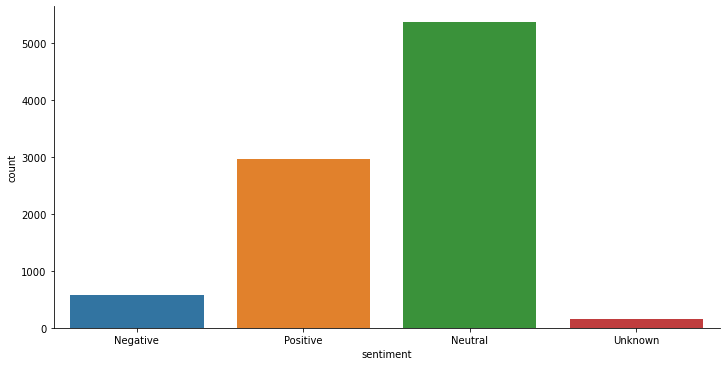

In [16]:
## Overall sentiment distribution
sns.catplot(data=df,x='sentiment',kind='count',order=sentiment_order,aspect=2);

#### Examing the class distributions

In [17]:
df['sentiment'].value_counts()

Neutral     5373
Positive    2968
Negative     569
Unknown      156
Name: sentiment, dtype: int64

In [18]:
df['sentiment'].value_counts(normalize=True)

Neutral     0.592654
Positive    0.327377
Negative    0.062762
Unknown     0.017207
Name: sentiment, dtype: float64

Less than half of the tweets were classified as having any emotion. Of the tweets which were tagged as having an emotion, most were coded positive. About 3,000 tweets compared to only 570 tweets that were tagged as having negative emotion.

In [19]:
df[df['sentiment']=='Unknown']

text  \
90                                     Thanks to @mention for publishing the news of @mention new medical Apps at the #sxswi conf. blog {link} #sxsw #sxswh   
102                         ÛÏ@mention &quot;Apple has opened a pop-up store in Austin so the nerds in town for #SXSW can get their new iPads. {link} #wow   
237                              Just what America needs. RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw   
341                                                                          The queue at the Apple Store in Austin is FOUR blocks long. Crazy stuff! #sxsw   
368                                       Hope it's better than wave RT @mention Buzz is: Google's previewing a social networking platform at #SXSW: {link}   
...                                                                                                                                                     ...   
9020              It's funny watching a room full of people hold their iPad in the air to take a photo. Like a room full of tablets staring you down. #SXSW   
9032                                                                                    @mention yeah, we have @mention , Google has nothing on us :) #SXSW   
9037                                                                      @mention Yes, the Google presentation was not exactly what I was expecting. #sxsw   
9058  &quot;Do you know what Apple is really good at? Making you feel bad about your Xmas present!&quot; - Seth Meyers on iPad2 #sxsw #doyoureallyneedthat?   
9066                    How much you want to bet Apple is disproportionately stocking the #SXSW pop-up store with iPad 2? The influencer/hipsters thank you   

     product sentiment  
90       NaN   Unknown  
102      NaN   Unknown  
237      NaN   Unknown  
341      NaN   Unknown  
368      NaN   Unknown  
...      ...       ...  
9020     NaN   Unknown  
9032     NaN   Unknown  
9037     NaN   Unknown  
9058     NaN   Unknown  
9066   Apple   Unknown  

[156 rows x 3 columns]

These tweets labeled as unknown are difficult to classify without more context and could be viewed as sarcastic.
All tweets in the corpus will need to be classified for modeling later on and the volume accounts for less than 2% of the corpus it is safe to drop these records.

In [20]:
df = df[df['sentiment']!='Unknown']
df['sentiment'].value_counts(normalize=True)

Neutral     0.603030
Positive    0.333109
Negative    0.063861
Name: sentiment, dtype: float64

Since the business problem we are looking to solve requires understanding differences between positive and negative sentiments, it is essential that positive and negative tweets are separated for the exploration process.

In [24]:
positive_df = df.loc[df['sentiment']=='Positive']
positive_df

text  \
1     @jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW   
2                                                                 @swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.   
4             @sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)   
7      #SXSW is just starting, #CTIA is around the corner and #googleio is only a hop skip and a jump from there, good time to be an #android fan   
8               Beautifully smart and simple idea RT @madebymany @thenextweb wrote about our #hollergram iPad app for #sxsw! http://bit.ly/ieaVOB   
...                                                                                                                                           ...   
9072                                @mention your iPhone 4 cases are Rad and Ready! Stop by tomorrow to get them! #Sxsw #zazzlesxsw #sxswi {link}   
9077                                             @mention your PR guy just convinced me to switch back to iPhone. Great #sxsw coverage. #princess   
9079                                                                       &quot;papyrus...sort of like the ipad&quot; - nice! Lol! #SXSW Lavelle   
9085    I've always used Camera+ for my iPhone b/c it has an image stabilizer mode. Suggestions for an iPad cam app w/ same feature? #SXSW #SXSWi   
9088                                                                                                                Ipad everywhere. #SXSW {link}   

                 product sentiment  
1     iPad or iPhone App  Positive  
2                   iPad  Positive  
4                 Google  Positive  
7                Android  Positive  
8     iPad or iPhone App  Positive  
...                  ...       ...  
9072              iPhone  Positive  
9077              iPhone  Positive  
9079                iPad  Positive  
9085  iPad or iPhone App  Positive  
9088                iPad  Positive  

[2968 rows x 3 columns]

In [25]:
negative_df = df.loc[df['sentiment']=='Negative']
negative_df

text  \
0                  .@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.   
3                                                               @sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw   
17                I just noticed DST is coming this weekend. How many iPhone users will be an hour late at SXSW come Sunday morning? #SXSW #iPhone   
38                         @mention  - False Alarm: Google Circles Not Coming NowÛÒand Probably Not Ever? - {link} #Google #Circles #Social #SXSW   
64                                                                                    Again? RT @mention Line at the Apple store is insane.. #sxsw   
...                                                                                                                                            ...   
8973                       Google guy at #sxsw talk is explaining how he made realistic Twitter bots as an experiment. Gee, thanks for doing that.   
8981                 I think my effing hubby is in line for an #iPad 2. Can someone point him towards the line-up for wife number #2. #sxswi #sxsw   
9008                              I'm pretty sure the panelist that thinks &quot;Apple is drowning in their success&quot; is fucking insane. #SXSW   
9043  Hey is anyone doing #sxsw signing up for the group texting app, groupme? got it on my iphone, but no one else is on it, so....kinda useless.   
9080         Diller says Google TV &quot;might be run over by the PlayStation and the Xbox, which are essentially ready today.&quot; #sxsw #diller   

                              product sentiment  
0                              iPhone  Negative  
3                  iPad or iPhone App  Negative  
17                             iPhone  Negative  
38                             Google  Negative  
64                                NaN  Negative  
...                               ...       ...  
8973                              NaN  Negative  
8981                             iPad  Negative  
9008                            Apple  Negative  
9043                              NaN  Negative  
9080  Other Google product or service  Negative  

[569 rows x 3 columns]

In [26]:
positive_corpus = positive_df['text'].to_list()
positive_corpus[:5]

["@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",
 '@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.',
 "@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",
 '#SXSW is just starting, #CTIA is around the corner and #googleio is only a hop skip and a jump from there, good time to be an #android fan',
 'Beautifully smart and simple idea RT @madebymany @thenextweb wrote about our #hollergram iPad app for #sxsw! http://bit.ly/ieaVOB']

In [27]:
negative_corpus = negative_df['text'].to_list()
negative_corpus[:5]

['.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.',
 "@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw",
 'I just noticed DST is coming this weekend. How many iPhone users will be an hour late at SXSW come Sunday morning? #SXSW #iPhone',
 '@mention  - False Alarm: Google Circles Not Coming Now\x89ÛÒand Probably Not Ever? - {link} #Google #Circles #Social #SXSW',
 'Again? RT @mention Line at the Apple store is insane.. #sxsw']

### Tokenization

In [28]:
from nltk import TweetTokenizer
import string

#Function for tokenization of tweets
def tweets_tokenize(corpus, preserve_case=False, strip_handles=True):
    
    tokenizer = TweetTokenizer(preserve_case=preserve_case, 
                               strip_handles=strip_handles)
    tokens = tokenizer.tokenize(','.join(corpus))
    
    return tokens

In [29]:
#positive tweets tokenized
positive_tokens = tweets_tokenize(positive_corpus)

In [30]:
#negative tweets tokenized
negative_tokens = tweets_tokenize(negative_corpus)

In [31]:
#checking the most common positive tokens
from nltk import FreqDist
freq = FreqDist(positive_tokens)
freq.most_common(10)

[(',', 4048),
 ('#sxsw', 2981),
 ('.', 2230),
 ('the', 1590),
 ('!', 1241),
 ('link', 1214),
 ('{', 1210),
 ('}', 1210),
 ('to', 1154),
 ('at', 1019)]

In [32]:
#checking the most common negative tokens
from nltk import FreqDist
freq = FreqDist(negative_tokens)
freq.most_common(10)

[(',', 789),
 ('#sxsw', 568),
 ('.', 545),
 ('the', 309),
 ('to', 256),
 ('ipad', 179),
 ('"', 175),
 ('is', 159),
 ('a', 155),
 ('iphone', 145)]

Looks like there are stop words and puncuations that were tokenized and will need to be removed. 

### Lemmatization

Before removing StopWords, tokens should be lemmatized to ensure the list of words are being captured

In [33]:
from nltk.stem.wordnet import WordNetLemmatizer
#nltk.download('wordnet')

#Function for lemmatizating tokens
def lemmatize_tokens(tokens_list):
    
    lemmatizer = WordNetLemmatizer()
    lemma_tokens = [lemmatizer.lemmatize(word) for word in tokens_list]
    return lemma_tokens

In [34]:
#Lemmatize positive tokens
positive_tokens_lemma = lemmatize_tokens(positive_tokens)

In [35]:
#Lemmatize negative tokens
negative_tokens_lemma = lemmatize_tokens(negative_tokens)

### Punctuation And StopWord Removal

In [36]:
#Import nltk's stopwords and add punctuation
from nltk.corpus import stopwords
stopword_list = stopwords.words('english')
stopword_list += list(string.punctuation)
#additional punctuation characters 
add_punct = ['“','”','...',"''",'’','``','']
stopword_list += add_punct

In [37]:
#Function to remove of StopWords
def stopword_removal(tokens, stopword_list=stopword_list):
    
    #encoding tokens to remove unrecognized characters and url links
    stopped_tokens = [w.encode('ascii','ignore').decode() for w in tokens 
                      if (w not in stopword_list) & 
                      (w.startswith('http') == False)]
    
    return stopped_tokens

In [38]:
#Removing StopWords from lemmatized tokens
positive_lemma_stopped = stopword_removal(positive_tokens_lemma)

In [39]:
#Removing StopWords from lemmatized tokens
negative_lemma_stopped = stopword_removal(negative_tokens_lemma)

In [40]:
#looking at the most common tokens
freq = FreqDist(positive_lemma_stopped)
freq.most_common(30)

[('#sxsw', 2981),
 ('link', 1218),
 ('ipad', 1008),
 ('rt', 929),
 ('apple', 711),
 ('google', 602),
 ('2', 593),
 ('store', 554),
 ('iphone', 466),
 ('', 443),
 ('app', 387),
 ('new', 358),
 ('austin', 250),
 ('get', 181),
 ('#apple', 174),
 ('launch', 173),
 ('android', 161),
 ('party', 151),
 ('pop-up', 151),
 ('sxsw', 144),
 ('line', 143),
 ('time', 136),
 ('great', 135),
 ('via', 132),
 ('#ipad2', 129),
 ('day', 124),
 ('social', 122),
 ('cool', 119),
 ('free', 118),
 ("i'm", 115)]

In [41]:
#looking at the most common tokens
freq = FreqDist(negative_lemma_stopped)
freq.most_common(30)

[('#sxsw', 568),
 ('ipad', 179),
 ('iphone', 145),
 ('rt', 138),
 ('google', 136),
 ('link', 103),
 ('apple', 100),
 ('2', 81),
 ('', 69),
 ('app', 60),
 ('store', 47),
 ('new', 43),
 ('like', 43),
 ('need', 35),
 ('ha', 31),
 ('circle', 29),
 ('design', 29),
 ('people', 29),
 ('social', 28),
 ('apps', 26),
 ('get', 25),
 ('wa', 24),
 ('austin', 23),
 ('think', 23),
 ('time', 23),
 ('launch', 22),
 ('one', 22),
 ('day', 21),
 ('today', 21),
 ('look', 21)]

In [42]:
# Appending stopwords list
stopword_list.extend(['rt','co','sxsw', '#sxsw', '#sxswi','link'])


In [43]:
#Removing StopWords from lemmatized tokens
positive_lemma_stopped = stopword_removal(positive_tokens_lemma)

In [44]:
#Removing StopWords from lemmatized tokens
negative_lemma_stopped = stopword_removal(negative_tokens_lemma)

In [45]:
#looking at the most common tokens
freq = FreqDist(positive_lemma_stopped)
freq.most_common(30)

[('ipad', 1008),
 ('apple', 711),
 ('google', 602),
 ('2', 593),
 ('store', 554),
 ('iphone', 466),
 ('', 443),
 ('app', 387),
 ('new', 358),
 ('austin', 250),
 ('get', 181),
 ('#apple', 174),
 ('launch', 173),
 ('android', 161),
 ('party', 151),
 ('pop-up', 151),
 ('line', 143),
 ('time', 136),
 ('great', 135),
 ('via', 132),
 ('#ipad2', 129),
 ('day', 124),
 ('social', 122),
 ('cool', 119),
 ('free', 118),
 ("i'm", 115),
 ('like', 115),
 ('map', 115),
 ('one', 114),
 ('today', 111)]

In [46]:
#looking at the most common tokens
freq = FreqDist(negative_lemma_stopped)
freq.most_common(30)

[('ipad', 179),
 ('iphone', 145),
 ('google', 136),
 ('apple', 100),
 ('2', 81),
 ('', 69),
 ('app', 60),
 ('store', 47),
 ('new', 43),
 ('like', 43),
 ('need', 35),
 ('ha', 31),
 ('circle', 29),
 ('design', 29),
 ('people', 29),
 ('social', 28),
 ('apps', 26),
 ('get', 25),
 ('wa', 24),
 ('austin', 23),
 ('think', 23),
 ('time', 23),
 ('launch', 22),
 ('one', 22),
 ('day', 21),
 ('today', 21),
 ('look', 21),
 ('line', 20),
 ('say', 20),
 ('android', 19)]

### WordCloud Visualizations

In [47]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


def wordcloud_generator(tokens, collocations=False, background_color='black', 
                       colormap='Greens', display=True):

    
    # Initalize a WordCloud
    wordcloud = WordCloud(collocations=collocations, 
                          background_color=background_color, 
                          colormap=colormap, 
                          width=500, height=300)

    # Generate wordcloud from tokens
    wordcloud.generate(','.join(tokens))

    # Plot with matplotlib
    if display:
        plt.figure(figsize = (12, 15), facecolor = None) 
        plt.imshow(wordcloud) 
        plt.axis('off');
        
    return wordcloud

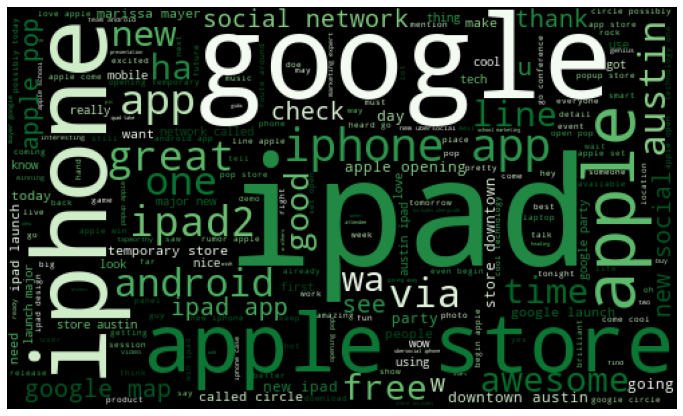

In [48]:
#generate a WordCloud for positive tweets
positive_cloud = wordcloud_generator(positive_lemma_stopped, collocations=True)

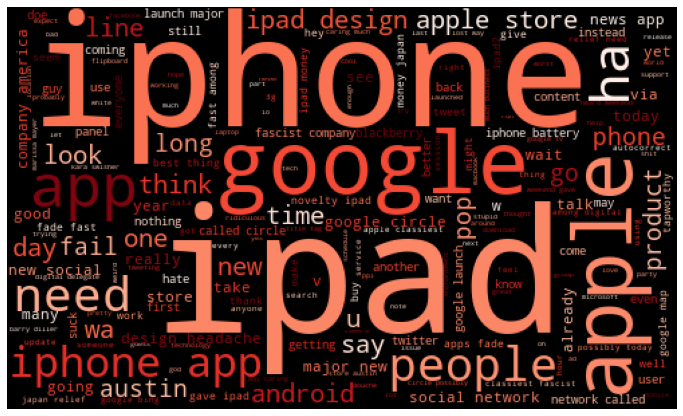

In [49]:
#generate a WordCloud for negative tweets
negative_cloud = wordcloud_generator(negative_lemma_stopped, colormap='Reds',
                                     collocations=True)

In [50]:
def wordcloud_comp(wc1, wc2):
 
    fig, ax = plt.subplots(figsize=(30,20), ncols=2)
    ax[0].imshow(wc1)
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[1].imshow(wc2)
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    plt.tight_layout();

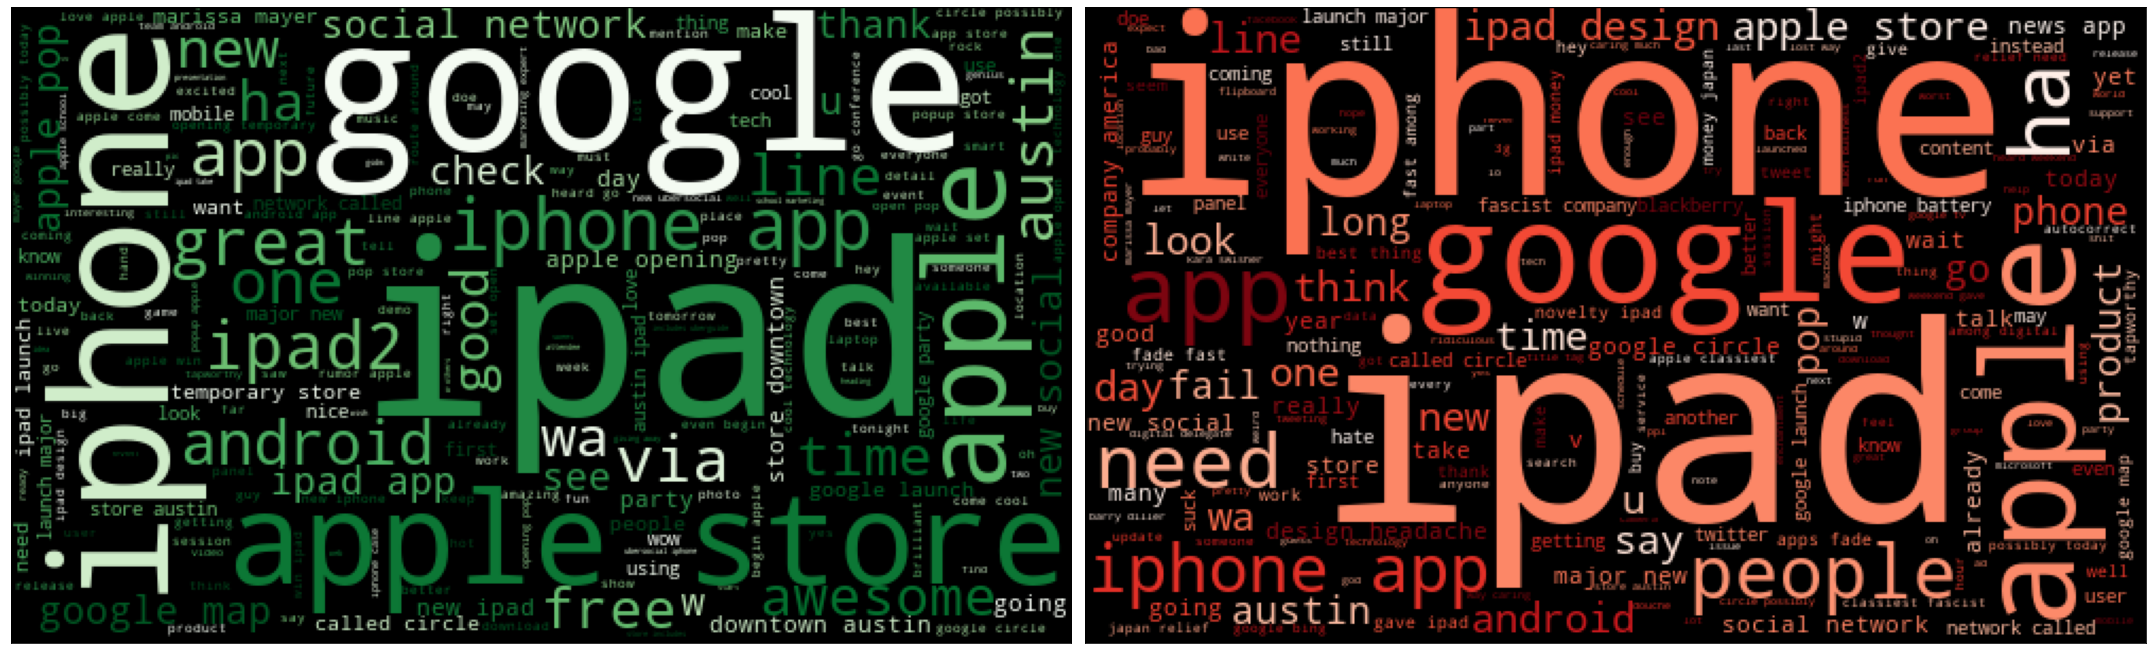

In [51]:
wordcloud_comp(positive_cloud, negative_cloud)

It looks like the brands presenting new services and  and product launches at the event appeared most in both positive and negative tweets. Let's look at WordClouds with those words added to the stop list.

In [52]:
#removing brands and products from the Wordcloud
stopword_list_no_brands = stopword_list + ['ipad', 'ipad2','#ipad2','apple', 'google', 'iphone', 
                           '#apple','#google', '#ipad', '#iphone', 'android']

positive_stopped_brands = stopword_removal(positive_tokens_lemma, stopword_list=stopword_list_no_brands)

In [53]:
negative_stopped_brands = stopword_removal(negative_tokens_lemma, stopword_list=stopword_list_no_brands)

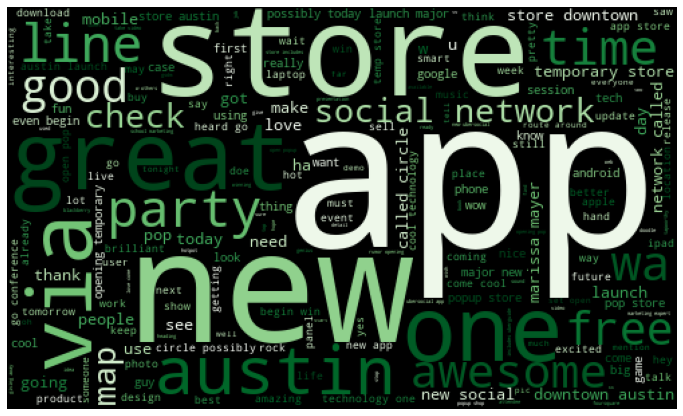

In [54]:
positive_cloud_no_names = wordcloud_generator(positive_stopped_brands, collocations=True)

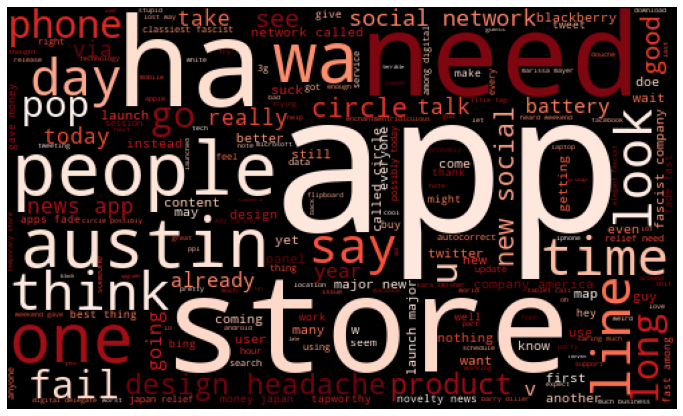

In [55]:
negative_cloud_no_names = wordcloud_generator(negative_stopped_brands, 
                                              colormap='Reds',collocations=True)

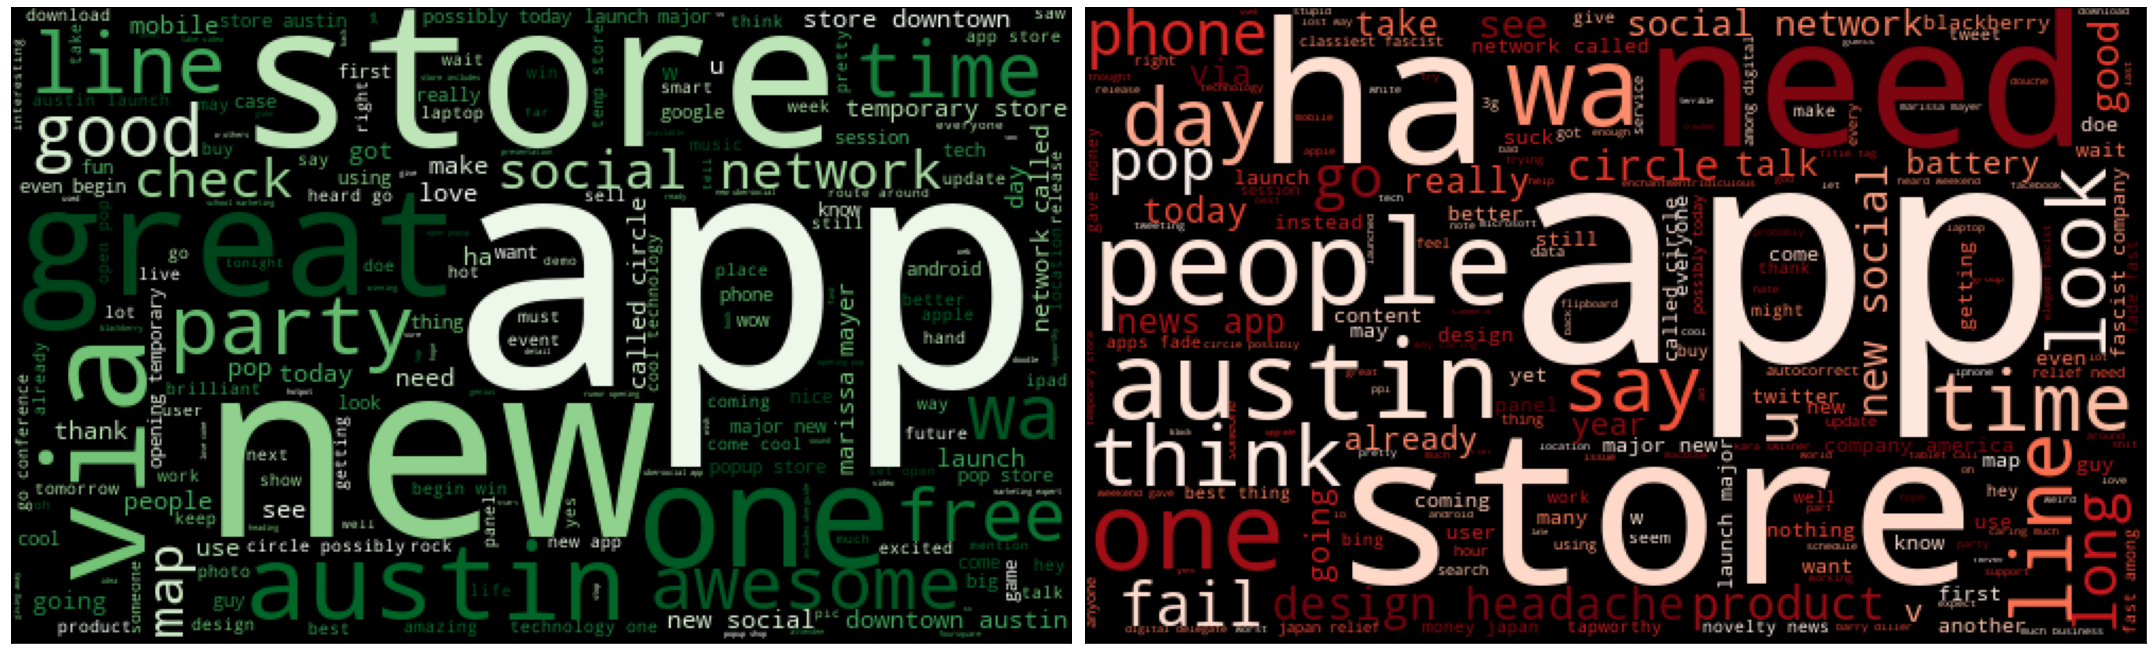

In [56]:
wordcloud_comp(positive_cloud_no_names,negative_cloud_no_names)

###  Tweet Bigrams

In [57]:
from nltk.collocations import *
bigram_measures = nltk.collocations.BigramAssocMeasures()

In [96]:
positive_finder = BigramCollocationFinder.from_words(positive_lemma_stopped)
negative_finder = BigramCollocationFinder.from_words(negative_lemma_stopped)

In [100]:
pos_bigrams = positive_finder.score_ngrams(bigram_measures.raw_freq)
neg_bigrams = negative_finder.score_ngrams(bigram_measures.raw_freq)

In [98]:
# Creating a DataFrame from the positive bigrams
pos_bigrams_df = pd.DataFrame(pos_bigrams, columns=["Word","Freq"]).head(10)

In [102]:
# Creating a DataFrame from the negative bigrams
neg_bigrams_df = pd.DataFrame(neg_bigrams, columns=["Word","Freq"]).head(10)

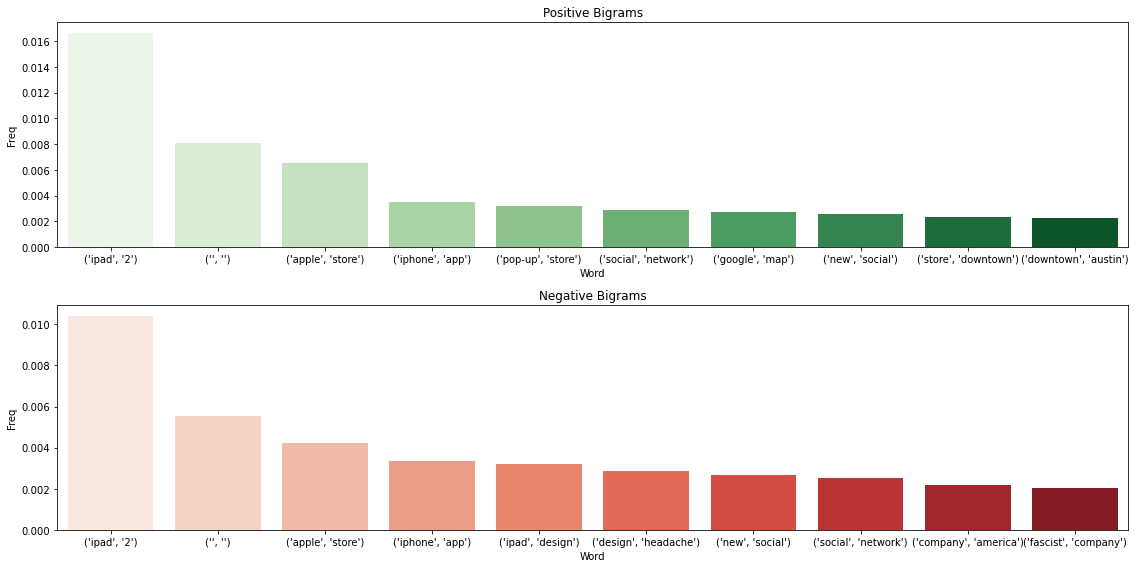

In [114]:
fig, axes = plt.subplots(figsize=(16,8),nrows=2)
sns.barplot(data=pos_bigrams_df, x=pos_bigrams_df['Word'],
            y=pos_bigrams_df['Freq'],ax=axes[0],palette='Greens')
sns.barplot(data=neg_bigrams_df, x=neg_bigrams_df['Word'], 
            y=neg_bigrams_df['Freq'],ax=axes[1],palette='Reds')
axes[0].set_title('Positive Bigrams')
axes[1].set_title('Negative Bigrams')
plt.tight_layout();

### Exploring Sentiments of Products/Services

In [79]:
df['product'].value_counts()

iPad                               939
Apple                              657
iPad or iPhone App                 469
Google                             427
iPhone                             295
Other Google product or service    292
Android App                         80
Android                             77
Other Apple product or service      35
Name: product, dtype: int64

In [80]:
product_order = ['iPad','Apple','iPad or iPhone App','Google','iPhone',
                 'Other Google product or service','Android App','Android',
                 'Other Apple product or service']

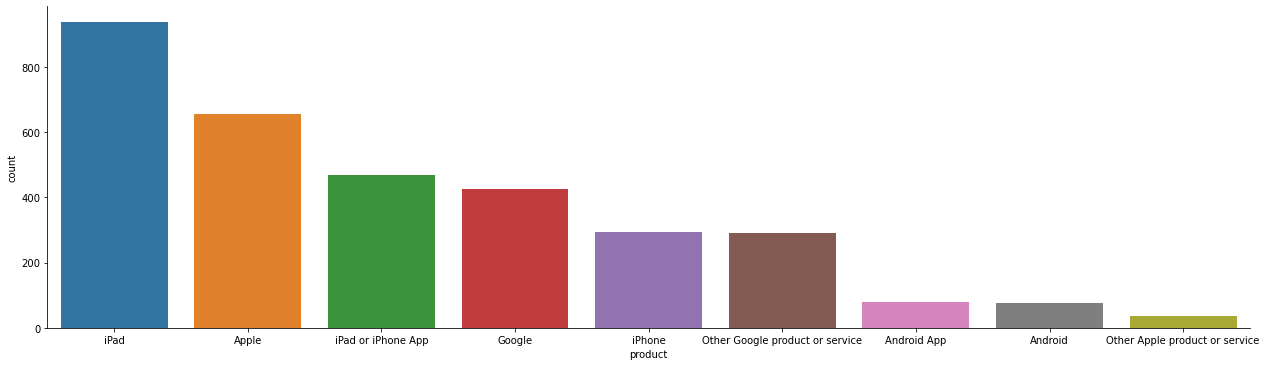

In [81]:
# Product tweet distribution
sns.catplot(data=df,x='product',kind='count',order=product_order,aspect=3.5);

In [82]:
#mapping products and services to their brand
product_dict={'iPad': 'Apple', 'Apple': 'Apple', 'iPad or iPhone App': 'Apple', 
              'Google': 'Google', 'iPhone': 'Apple', 
              'Other Google product or service': 'Google',
              'Android App': 'Google', 'Android': 'Google',
              'Other Apple product or service': 'Apple'}

df['brand'] = df['product'].map(product_dict)

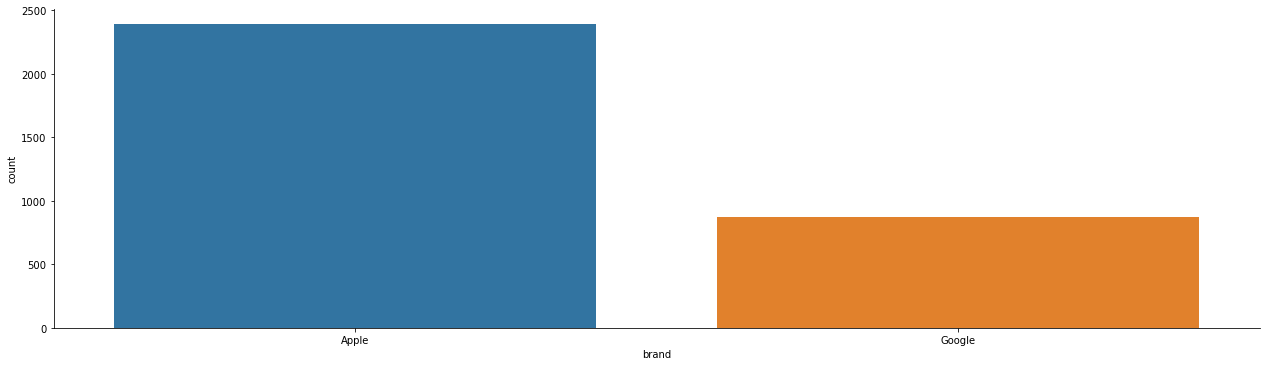

In [83]:
# Brand tweet distribution
sns.catplot(data=df,x='brand',kind='count',order=['Apple', 'Google'],aspect=3.5);

In [84]:
df.groupby(['brand','product','sentiment']).count()

text
brand  product                         sentiment      
Apple  Apple                           Negative     95
                                       Neutral      21
                                       Positive    541
       Other Apple product or service  Negative      2
                                       Neutral       1
                                       Positive     32
       iPad                            Negative    125
                                       Neutral      24
                                       Positive    790
       iPad or iPhone App              Negative     63
                                       Neutral      10
                                       Positive    396
       iPhone                          Negative    102
                                       Neutral       9
                                       Positive    184
Google Android                         Negative      8
                                       Neutral       1
                                       Positive     68
       Android App                     Negative      8
                                       Neutral       1
                                       Positive     71
       Google                          Negative     68
                                       Neutral      15
                                       Positive    344
       Other Google product or service Negative     47
                                       Neutral       9
                                       Positive    236

# MODEL

## Preprocessing for binary modeling

Since the business problem is only concerned with classifying tweets as negative or positive a binary classification model will be employed. Therefore we are going to be developing a model for binary classification, we need to binarize the target column, which in this case in the 'sentiment' column. 

In [125]:
df['sentiment'].value_counts()

Neutral     5373
Positive    2968
Negative     569
Name: sentiment, dtype: int64

In [121]:
# create X and y from only tweets labeled as having a positive or negative sentiment
X = df.loc[df['sentiment'].isin(['Positive', 'Negative']), 
           'text']
y = df.loc[df['sentiment'].isin(['Positive', 'Negative']), 
           'sentiment']

In [124]:
# Dicts to transform labels into binary
binary_key = {'Negative':1, 'Positive': 0}

# Map class labels to binary
y = y.map(lambda x: binary_key[x])
y.value_counts()

0    2968
1     569
Name: sentiment, dtype: int64

#### Binary Classification Evaluator

In [129]:
def clf_eval(y_true, y_pred, X_test, X_train, clf):
    
    
    print(f"Training Score: {round(clf.score(X_train, y_train),2)} \
            Test Score:{round(clf.score(X_test, y_true),2)}")
    
   
    print("\n")
    print("Classification Report")
    print("------------------------------------------")
    print(classification_report(y_true=y_true, y_pred=y_pred))
    
    
    fig, ax = plt.subplots(ncols=2, figsize=(12, 5))
    
    plot_confusion_matrix(estimator=clf, X=X_test, y_true=y_true, cmap='Blues', 
                          normalize='true', ax=ax[0], 
                          display_labels=['Negative','Positive'])
 
    pred_prob = clf.predict_proba(X_test)

    
    
 
    try:
        roc_curve = metrics.plot_roc_curve(clf,X_test_tf,y_test,ax=ax[1])
        curve.ax_.grid()
        curve.ax_.plot([0,1],[0,1],ls=':')
        fig.tight_layout()
    except:
        fig.delaxes(ax[1])
    plt.show()

        

#### Baseline Model

Baseline model will be used to measure how well our model performs compared to random guessing.

#### Train Test Split

In [126]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                               stratify=y)
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

2829
2829
708
708


In [127]:
y_train.value_counts(normalize=True)

0    0.839166
1    0.160834
Name: sentiment, dtype: float64

In [128]:
y_test.value_counts(normalize=True)

0    0.838983
1    0.161017
Name: sentiment, dtype: float64

In [118]:
tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True)

Training Score: 0.48             Test Score:0.47


Classification Report
------------------------------------------
              precision    recall  f1-score   support

    Negative       0.05      0.05      0.05       149
     Neutral       0.59      0.60      0.60      1336
    Positive       0.34      0.33      0.33       743

    accuracy                           0.47      2228
   macro avg       0.33      0.33      0.33      2228
weighted avg       0.47      0.47      0.47      2228



ValueError: The number of FixedLocator locations (3), usually from a call to set_ticks, does not match the number of ticklabels (2).

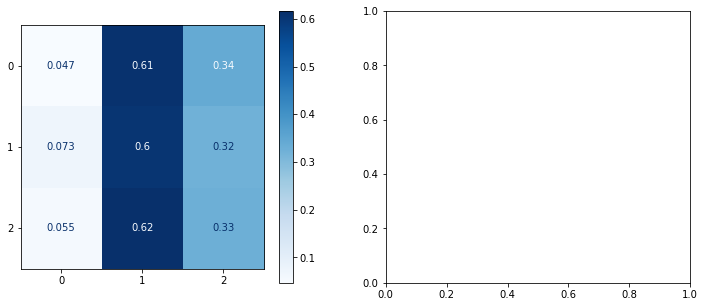

In [119]:
from sklearn.dummy import DummyClassifier

clf_pipe = Pipeline([('vectorizer', TfidfVectorizer(tokenizer=tokenizer.tokenize, 
                                                    stop_words=stopword_list)),
                     ('clf', DummyClassifier(random_state=42))])

clf_pipe.fit(X_train, y_train)
y_pred = clf_pipe.predict(X_test)
clf_eval(y_test, y_pred, X_test, X_train, clf_pipe)



## Naive Bayes


In [93]:
mnb_text_pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=tokenizer.tokenize, 
                                   stop_words=stopword_list)),
    ('clf', MultinomialNB())
])

Training Score: 0.76             Test Score:0.67


Classification Report
------------------------------------------
              precision    recall  f1-score   support

    Negative       1.00      0.02      0.04       149
     Neutral       0.66      0.95      0.78      1336
    Positive       0.74      0.30      0.42       743

    accuracy                           0.67      2228
   macro avg       0.80      0.42      0.41      2228
weighted avg       0.71      0.67      0.61      2228



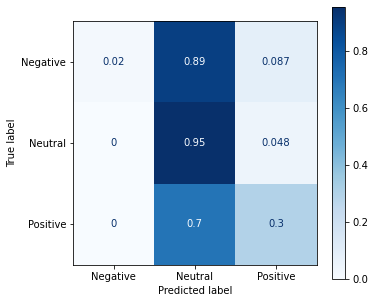

In [94]:
mnb_text_pipe.fit(X_train, y_train)
y_pred = mnb_text_pipe.predict(X_test)
clf_eval(y_test, y_pred, X_test, X_train, mnb_text_pipe)

## Logistic Regression

In [ ]:
lr_text_pipe = Pipeline([('vectorizer', TfidfVectorizer(tokenizer=tokenizer.tokenize, 
                                   stop_words=stopword_list)), 
    ('clf', LogisticRegressionCV(solver='saga',max_iter=500, class_weight='balanced', random_state=42,n_jobs=-1))
])

In [ ]:
lr_text_pipe.fit(X_train, y_train)
y_pred = lr_text_pipe.predict(X_test)
clf_eval(y_test, y_pred, X_test, X_train, lr_text_pipe)

#### Hyperparameter Tuning with GridSearchCV

In [ ]:
param_grid = {'clf__class_weight': ['balanced'],
              'clf__max_iter': [100, 500, 1000],
              'clf__Cs': [[0.01], [0.1], [1]],
              'clf__solver': ['liblinear', 'lbfgs', 'sag', 'saga']}

gs = GridSearchCV(estimator=lr_text_pipe, param_grid = param_grid, 
                              scoring='recall_macro')

gs.fit(X_train,  y_train)
gs.best_params_

### Tuned LR Model

In [ ]:
tuned_lr_text_pipe = Pipeline([('vectorizer', TfidfVectorizer(tokenizer=tokenizer.tokenize, 
                                   stop_words=stopword_list)), 
    ('clf', LogisticRegressionCV(solver='liblinear',
                                 max_iter=100, 
                                 class_weight='balanced',
                                 Cs=1,
                                 random_state=42,
                                 n_jobs=-1))
])

In [ ]:
tuned_lr_text_pipe.fit(X_train, y_train)
y_pred = tuned_lr_text_pipe.predict(X_test)
clf_eval(y_test, y_pred, X_test, X_train, tuned_lr_text_pipe)

## RandomForest

In [ ]:
rf_text_pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=tokenizer.tokenize, 
                                   stop_words=stopword_list)), 
    ('clf', RandomForestClassifier(class_weight='balanced', random_state=42))
])

In [ ]:
rf_text_pipe.fit(X_train, y_train)
y_pred = rf_text_pipe.predict(X_test)
clf_eval(y_test, y_pred, X_test, X_train, rf_text_pipe)

# Interpreting Results

## Best Model

Evaluate how well your work solves the stated business problem.



***
Questions to consider:
* How do you interpret the results?
* How well does your model fit your data? How much better is this than your baseline model?
* How confident are you that your results would generalize beyond the data you have?
* How confident are you that this model would benefit the business if put into use?
***

In [ ]:
def plot_importance(clf_pipe, n_features, title):
   
    feats = clf_pipe['vectorizer'].get_feature_names()
    coefs = clf_pipe['clf'].coef_[0]
    
    importance_df = pd.DataFrame(feats, columns=['Word'])
    importance_df['Importance'] = math.e**(abs(coefs))
    importance_df['Coefficient'] = coefs

    feat_importance = importance_df.sort_values(by = ["Importance"], 
                                                   ascending=False).head(n_features)
    
    fig, ax = plt.subplots(figsize=(15,10), ncols=2)
    ax[0].set_title(f'Coefficients for {title}')
    ax[0].set_ylabel('Word')
    ax[0].set_xlabel('Coefficient')
    sns.barplot(x='Coefficient', y='Word', palette='magma', data=feat_importance, ax=ax[0])

    ax[1].set_title(f'Feature Importances for {title}')
    ax[1].set_ylabel('Word')
    ax[1].set_xlabel('Importance')
    sns.barplot(x='Importance', y='Word', palette='magma', data=feat_importance, ax=ax[1])
    plt.tight_layout();

In [ ]:
plot_importance(lr_text_pipe, 15, 'Tuned Logistic Regression Model')

# CONCLUSIONS & RECOMMENDATIONS

## Recommendations

## Limitations & Next Steps